### Preprocessing parameters
<hr>

- sampling_rate = 22050
- hop_length = 256
- duration = 5
- n_mels = 96
- nfft = 512

Clips with length less than 5 seconds were padded using 'wrap' and 'constant'.<br> 
Data augmentation was performed to increase dataset size.

<hr>

### Model

In [1]:
import os
os.listdir('/kaggle/input')

['esc-animalsounds']

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/esc-animalsounds'):
    c = 0
    for filename in filenames:
        c += 1
        
    if c>0: 
        print("{} : {} images".format(dirname,c))
        print("--------------")

/kaggle/input/esc-animalsounds/animal_sounds/Pig : 47 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Cow : 48 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Hen : 46 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Dog : 56 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Insects : 43 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Crickets : 40 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Frog : 41 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Rooster : 76 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Chirping birds : 41 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Sheep : 42 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Crow : 50 images
--------------
/kaggle/input/esc-animalsounds/animal_sounds/Cat : 53 images
--------------


In [3]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [4]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # sigmoid activation for multi-label classification
        model.add(Dense(classes))
        model.add(Activation(finalAct))
        # return the constructed network architecture
        return model

In [5]:
import matplotlib
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [6]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (150, 200, 3)

In [7]:
imagePaths = []
for dirname, _, filenames in os.walk(r'/kaggle/input/esc-animalsounds/'):
    for filename in filenames:
        imagePaths.append(os.path.join(dirname, filename))
        
imagePaths = sorted(imagePaths)
random.seed(42)
random.shuffle(imagePaths)

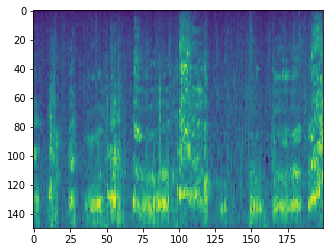

In [8]:
image = imagePaths[4]
image = cv2.imread(image)
image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
plt.show()

In [9]:
data = []
labels = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    l = label = imagePath.split(os.path.sep)[-2]
    labels.append((l,))
    
labels[0:5]

[('Pig',), ('Sheep',), ('Insects',), ('Sheep',), ('Pig',)]

In [10]:
print(len(data))
print(len(labels))

583
583


In [11]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [12]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print(len(mlb.classes_))
print(mlb.classes_)

12
['Cat' 'Chirping birds' 'Cow' 'Crickets' 'Crow' 'Dog' 'Frog' 'Hen'
 'Insects' 'Pig' 'Rooster' 'Sheep']


In [13]:
(train_X, valid_X, train_y, valid_y) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [14]:
model = SmallerVGGNet.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
    finalAct="sigmoid"
)

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 200, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 200, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 200, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 66, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 66, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 66, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 66, 64)       

In [16]:
fit_results = model.fit(
    train_X, train_y,
    epochs = EPOCHS,
    batch_size = BS,
    validation_data = (valid_X, valid_y),
    verbose=1
)

Train on 466 samples, validate on 117 samples
Epoch 1/100
466/466 [==============================] - 7s 15ms/step - loss: 0.8787 - accuracy: 0.5574 - val_loss: 0.6734 - val_accuracy: 0.7009
Epoch 2/100
466/466 [==============================] - 1s 2ms/step - loss: 0.6698 - accuracy: 0.6486 - val_loss: 0.6568 - val_accuracy: 0.6923
Epoch 3/100
466/466 [==============================] - 1s 3ms/step - loss: 0.5788 - accuracy: 0.7169 - val_loss: 0.6951 - val_accuracy: 0.6895
Epoch 4/100
466/466 [==============================] - 1s 2ms/step - loss: 0.4941 - accuracy: 0.7722 - val_loss: 0.6849 - val_accuracy: 0.6439
Epoch 5/100
466/466 [==============================] - 1s 2ms/step - loss: 0.3795 - accuracy: 0.8559 - val_loss: 0.5033 - val_accuracy: 0.7956
Epoch 6/100
466/466 [==============================] - 1s 2ms/step - loss: 0.2784 - accuracy: 0.9002 - val_loss: 0.3438 - val_accuracy: 0.9167
Epoch 7/100
466/466 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0

Text(0.5, 1.0, 'Accuracy')

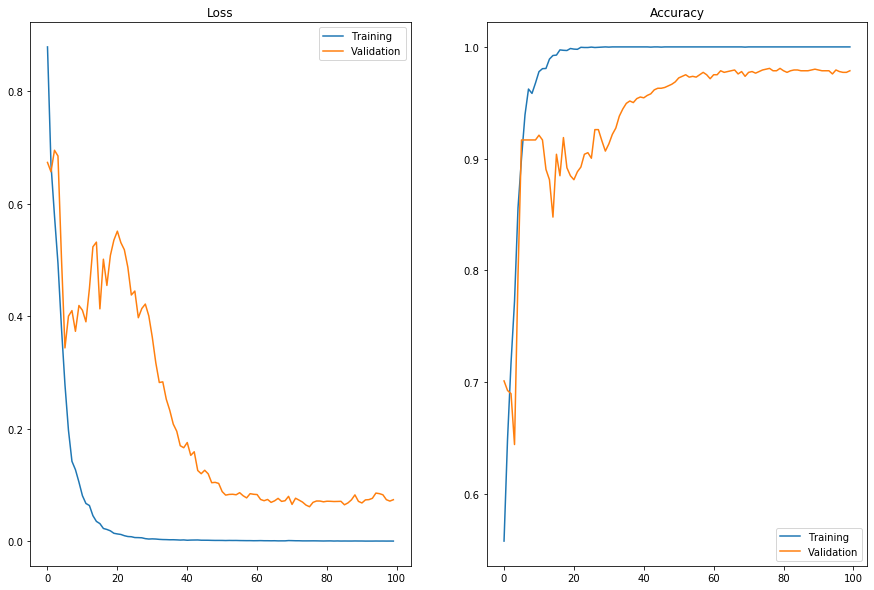

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.plot(fit_results.history['loss'], label='Training')
ax1.plot(fit_results.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(fit_results.history['accuracy'], label='Training')
ax2.plot(fit_results.history['val_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Accuracy')

In [ ]:
model.save('AnimalSounds_SmallerVGGNet.h5')

f = open("AS_VGGN.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()